<a href="https://colab.research.google.com/github/Bruminiu/Projekt-ai/blob/main/ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d ashishjangra27/gender-recognition-200k-images-celeba

Dataset URL: https://www.kaggle.com/datasets/ashishjangra27/gender-recognition-200k-images-celeba
License(s): CC-BY-NC-SA-4.0
100% 1.32G/1.32G [01:08<00:00, 19.3MB/s]
100% 1.32G/1.32G [01:08<00:00, 20.7MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/gender-recognition-200k-images-celeba.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import os
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras import regularizers


from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import load_img

from tqdm.notebook import tqdm
from keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image



from tensorflow.keras.models import Sequential
from keras import layers

In [5]:
BASE_DIR_train_male ="/content/Dataset/Train/Male"
BASE_DIR_train_female ="/content/Dataset/Train/Female"

BASE_DIR_val_male ="/content/Dataset/Validation/Male"
BASE_DIR_val_female ="/content/Dataset/Validation/Female"

BASE_DIR_test_male ="/content/Dataset/Test/Male"
BASE_DIR_test_female ="/content/Dataset/Test/Female"

In [6]:
gender_classes=["Male", "Female"]

In [7]:
image_paths_train = []
gender_labels_train = []

for filename in tqdm(os.listdir(BASE_DIR_train_male)):
    image_path = os.path.join(BASE_DIR_train_male, filename)
    image_paths_train.append(image_path)
    gender_labels_train.append("Male")

  0%|          | 0/67155 [00:00<?, ?it/s]

In [8]:
for filename in tqdm(os.listdir(BASE_DIR_train_female)):
    image_path = os.path.join(BASE_DIR_train_female, filename)
    image_paths_train.append(image_path)
    gender_labels_train.append("Female")

  0%|          | 0/92845 [00:00<?, ?it/s]

In [9]:
for filename in tqdm(os.listdir(BASE_DIR_val_male)):
    image_path = os.path.join(BASE_DIR_val_male, filename)
    image_paths_train.append(image_path)
    gender_labels_train.append("Male")

  0%|          | 0/8820 [00:00<?, ?it/s]

In [10]:
for filename in tqdm(os.listdir(BASE_DIR_val_female)):
    image_path = os.path.join(BASE_DIR_val_female, filename)
    image_paths_train.append(image_path)
    gender_labels_train.append("Female")

  0%|          | 0/13778 [00:00<?, ?it/s]

In [11]:
image_paths_test = []
gender_labels_test = []

for filename in tqdm(os.listdir(BASE_DIR_test_male)):
    image_path = os.path.join(BASE_DIR_test_male, filename)
    image_paths_test.append(image_path)
    gender_labels_test.append("Male")

  0%|          | 0/8459 [00:00<?, ?it/s]

In [12]:
for filename in tqdm(os.listdir(BASE_DIR_test_female)):
    image_path = os.path.join(BASE_DIR_test_female, filename)
    image_paths_test.append(image_path)
    gender_labels_test.append("Female")

  0%|          | 0/11542 [00:00<?, ?it/s]

In [13]:
df_gender_train = pd.DataFrame()
df_gender_train['image'], df_gender_train['gender'] = image_paths_train, gender_labels_train
df_gender_train.head()

,image,gender
0,/content/Dataset/Train/Male/090274.jpg,Male
1,/content/Dataset/Train/Male/115406.jpg,Male
2,/content/Dataset/Train/Male/114632.jpg,Male
3,/content/Dataset/Train/Male/014002.jpg,Male
4,/content/Dataset/Train/Male/006856.jpg,Male


In [14]:
df_gender_test = pd.DataFrame()
df_gender_test['image'], df_gender_test['gender'] = image_paths_test, gender_labels_test
df_gender_test.head()

,image,gender
0,/content/Dataset/Test/Male/165126.jpg,Male
1,/content/Dataset/Test/Male/179283.jpg,Male
2,/content/Dataset/Test/Male/162958.jpg,Male
3,/content/Dataset/Test/Male/172243.jpg,Male
4,/content/Dataset/Test/Male/160562.jpg,Male


In [15]:
df_gender_test=df_gender_test.sample(frac=1)

In [16]:
df_gender_train=df_gender_train.sample(frac=1)

In [17]:
df_gender_train.tail()

,image,gender
48930,/content/Dataset/Train/Male/054025.jpg,Male
110843,/content/Dataset/Train/Female/088635.jpg,Female
5539,/content/Dataset/Train/Male/070673.jpg,Male
91249,/content/Dataset/Train/Female/077007.jpg,Female
72722,/content/Dataset/Train/Female/100880.jpg,Female


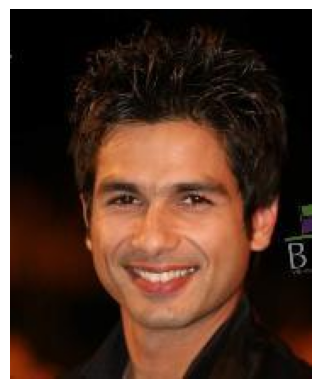

In [18]:
img = Image.open(df_gender_train['image'][0])
plt.axis('off')
plt.imshow(img);

In [19]:
img=cv2.imread(df_gender_train['image'][288])
img.shape

(218, 178, 3)

In [20]:
def gender_bin(gender):

    if gender=='Male':
        return 0
    else:
        return 1

In [21]:
df_gender_train['gender_bin']=df_gender_train['gender'].apply(gender_bin)
df_gender_test['gender_bin']=df_gender_test['gender'].apply(gender_bin)

In [22]:
df_gender_train

,image,gender,gender_bin
68895,/content/Dataset/Train/Female/110091.jpg,Female,1
174411,/content/Dataset/Validation/Female/188758.jpg,Female,1
111417,/content/Dataset/Train/Female/128461.jpg,Female,1
124312,/content/Dataset/Train/Female/149321.jpg,Female,1
100807,/content/Dataset/Train/Female/004410.jpg,Female,1
...,...,...,...
48930,/content/Dataset/Train/Male/054025.jpg,Male,0
110843,/content/Dataset/Train/Female/088635.jpg,Female,1
5539,/content/Dataset/Train/Male/070673.jpg,Male,0
91249,/content/Dataset/Train/Female/077007.jpg,Female,1


In [23]:
df_gender_test

,image,gender,gender_bin
17415,/content/Dataset/Test/Female/162168.jpg,Female,1
18453,/content/Dataset/Test/Female/174079.jpg,Female,1
10827,/content/Dataset/Test/Female/167671.jpg,Female,1
19460,/content/Dataset/Test/Female/175894.jpg,Female,1
10696,/content/Dataset/Test/Female/174421.jpg,Female,1
...,...,...,...
9174,/content/Dataset/Test/Female/177344.jpg,Female,1
8749,/content/Dataset/Test/Female/179902.jpg,Female,1
16728,/content/Dataset/Test/Female/179761.jpg,Female,1
5308,/content/Dataset/Test/Male/161798.jpg,Male,0


In [24]:
df_gender_train['gender'].value_counts()

gender
Female    106623
Male       75975
Name: count, dtype: int64

In [25]:
df_gender_test['gender'].value_counts()

gender
Female    11542
Male       8459
Name: count, dtype: int64

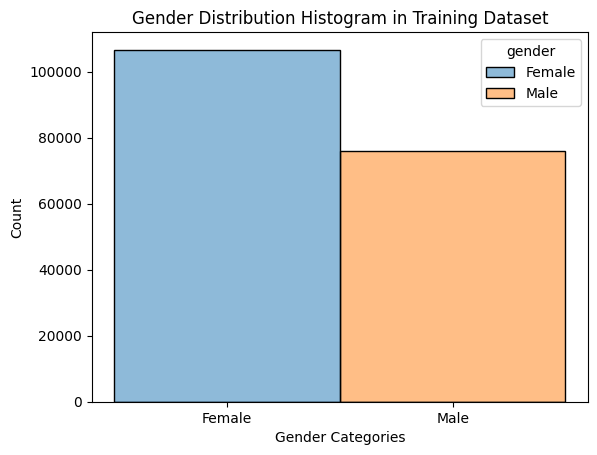

(None,)

In [26]:
import warnings
warnings.filterwarnings("ignore")

sns.histplot(x=df_gender_train['gender'], hue='gender', data=df_gender_train)
plt.title('Gender Distribution Histogram in Training Dataset')
plt.xlabel('Gender Categories')
plt.show(),

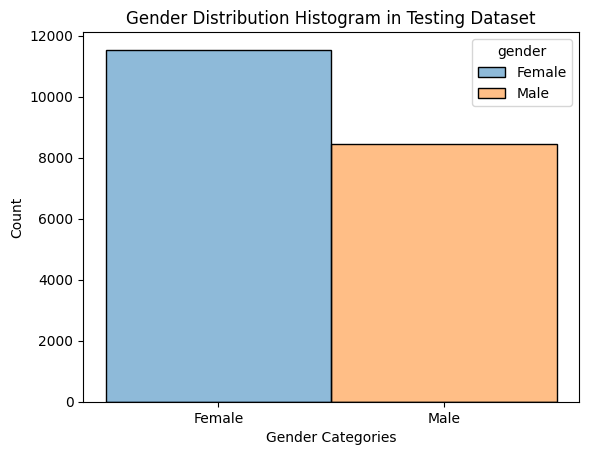

(None,)

In [27]:
sns.histplot(x=df_gender_test['gender'], hue='gender', data=df_gender_test)
plt.title('Gender Distribution Histogram in Testing Dataset')
plt.xlabel('Gender Categories')
plt.show(),

In [28]:
train_image_list = list(df_gender_train['image'])
train_labels_list = list(df_gender_train['gender_bin'])

test_image_list = list(df_gender_test['image'])
test_labels_list = list(df_gender_test['gender_bin'])

In [29]:
train_image_list_tf = tf.constant(train_image_list)
train_labels_list_tf = tf.constant(train_labels_list)

test_image_list_tf = tf.constant(test_image_list)
test_labels_list_tf = tf.constant(test_labels_list)

In [30]:
num_classes = 2
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)

    image_resized = tf.image.resize(image_decoded, [218, 178])

    image_normalized = image_resized / 255.0


    label = tf.one_hot(label, num_classes)

    return image_normalized, label

In [31]:
train_image_dataset = tf.data.Dataset.from_tensor_slices((train_image_list_tf, train_labels_list_tf))
train_image_dataset = train_image_dataset.map(_parse_function)
train_image_dataset = train_image_dataset.batch(128)


test_image_dataset = tf.data.Dataset.from_tensor_slices((test_image_list_tf, test_labels_list_tf))
test_image_dataset = test_image_dataset.map(_parse_function)
test_image_dataset = test_image_dataset.batch(128)

In [32]:
train_image_dataset


<_BatchDataset element_spec=(TensorSpec(shape=(None, 218, 178, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [33]:
model = tf.keras.models.Sequential()


model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(218, 178,3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))


model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())


model.add(layers.Dense(2, activation='sigmoid'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 216, 176, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 216, 176, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 108, 88, 64)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 86, 128)      73856     
                                                                 
 batch_normalization_1 (Bat  (None, 106, 86, 128)      512       
 chNormalization)                                                
                                                        

In [34]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True)


callbacks_list=[early_stopping_callback]

model.compile(optimizer="adam", loss=['binary_crossentropy'], metrics=['binary_accuracy'])

In [35]:
history=model.fit(
    train_image_dataset,
    batch_size=128,
    epochs=3,
    callbacks=callbacks_list,
    validation_data=test_image_dataset,
    verbose=1,
    shuffle=False
)

Epoch 1/3
1427/1427 [==============================] - 1124s 772ms/step - loss: 0.1808 - binary_accuracy: 0.9220 - val_loss: 0.4384 - val_binary_accuracy: 0.8425
Epoch 2/3
1427/1427 [==============================] - 1076s 754ms/step - loss: 0.0831 - binary_accuracy: 0.9685 - val_loss: 0.1689 - val_binary_accuracy: 0.9368
Epoch 3/3
1427/1427 [==============================] - 1076s 754ms/step - loss: 0.0671 - binary_accuracy: 0.9750 - val_loss: 0.2903 - val_binary_accuracy: 0.8994


In [36]:
y_predict = model.predict(test_image_dataset)

157/157 [==============================] - 17s 109ms/step


In [37]:
model.evaluate(test_image_dataset)

157/157 [==============================] - 18s 112ms/step - loss: 0.2903 - binary_accuracy: 0.8994


[0.29027149081230164, 0.8993550539016724]

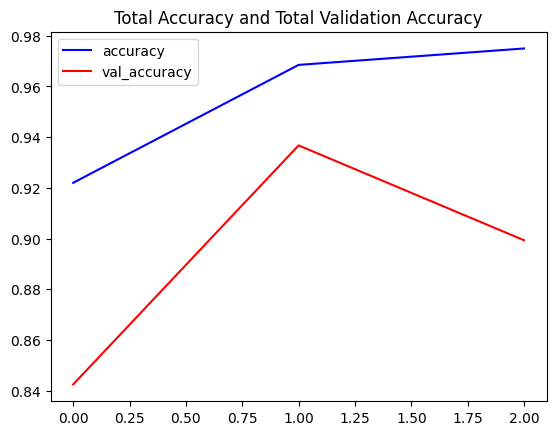

In [39]:
epochs = range(len(history.history["loss"]))
plt.plot(epochs, history.history["binary_accuracy"], 'blue', label = "accuracy")
plt.plot(epochs, history.history["val_binary_accuracy"], 'red', label ="val_accuracy")
plt.title("Total Accuracy and Total Validation Accuracy")
plt.legend()

In [40]:
model.save('gender_model.h5')